# Anomaly detection

### Import libraries

In [1]:
import copy
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer as normalizer
import pytagi.metric as metric


### Import from Canari

In [2]:
from canari import (
    DataProcess,
    Model,
    SKF,
    plot_data,
    plot_prediction,
    plot_states,
    plot_skf_states,
)
from canari.component import LocalTrend, LocalAcceleration, LstmNetwork, WhiteNoise

/opt/miniconda3/envs/canari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-26 14:09:56,885	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-26 14:09:56,972	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Read data

In [3]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data/toy_time_series/sine.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
# Add synthetic anomaly to data
trend = np.linspace(0, 0, num=len(df))
time_anomaly = 120
new_trend = np.linspace(0, 1, num=len(df) - time_anomaly)
trend[time_anomaly:] = trend[time_anomaly:] + new_trend
df = df.add(trend, axis=0)
#
data_file_time = str(project_root / "data/toy_time_series/sine_datetime.csv")
time_index = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_index = pd.to_datetime(time_index[0])
df.index = time_index
df.index.name = "time"
df.columns = ["values"]

### Data preprocess

In [4]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    time_covariates=["hour_of_day"],
    train_split=0.4,
    validation_split=0.1,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()
data_processor.data.head()

,values,hour_of_day
time,,
2000-01-03 00:00:00,0.00,0.0
2000-01-03 01:00:00,-0.26,1.0
2000-01-03 02:00:00,-0.50,2.0
2000-01-03 03:00:00,-0.71,3.0
2000-01-03 04:00:00,-0.87,4.0


### Define components

In [5]:
local_trend = LocalTrend()
local_acceleration = LocalAcceleration()
pattern = LstmNetwork(
    look_back_len=10,
    num_features=2,
    num_layer=1,
    num_hidden_unit=50,
    device="cpu",
    manual_seed=1,
)
residual = WhiteNoise(std_error=5e-2)

### Define normal and abnormal models

In [6]:
# Normal model
model = Model(local_trend, pattern, residual)

#  Abnormal model
ab_model = Model(local_acceleration, pattern, residual)

### Define Switching Kalman Filter (SKF) model

In [7]:
skf = SKF(
    norm_model=model,
    abnorm_model=ab_model,
    std_transition_error=1e-4,
    norm_to_abnorm_prob=1e-4,
)
skf.auto_initialize_baseline_states(train_data["y"][0 : 52 * 3])

### Train model, i.e. LSTM neural network

In [8]:

num_epoch = 50
states_optim = None
mu_validation_preds_optim = None
std_validation_preds_optim = None

for epoch in range(num_epoch):
    mu_validation_preds, std_validation_preds, states = skf.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )

    # Unstandardize the predictions
    mu_validation_preds_unnorm = normalizer.unstandardize(
        mu_validation_preds,
        data_processor.std_const_mean[data_processor.output_col],
        data_processor.std_const_std[data_processor.output_col],
    )

    std_validation_preds_unnorm = normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.std_const_std[data_processor.output_col],
    )

    validation_obs = data_processor.get_data("validation").flatten()
    validation_log_lik = metric.log_likelihood(
        prediction=mu_validation_preds_unnorm,
        observation=validation_obs,
        std=std_validation_preds_unnorm,
    )

    skf.early_stopping(evaluate_metric=-validation_log_lik, current_epoch=epoch, max_epoch=num_epoch)

    if epoch == skf.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds.copy()
        std_validation_preds_optim = std_validation_preds.copy()
        states_optim = copy.copy(states)
    
    skf.model["norm_norm"].set_memory(states=states, time_step=0)
    if skf.stop_training:
        break

print(f"Optinal epoch               : {skf.optimal_epoch}")
print(f"Validation Log-likelihood   :{skf.early_stop_metric: 0.4f}")

Optinal epoch               : 49
Validation Log-likelihood   :-1.4718


### Anomaly detection

In [9]:
filter_marginal_abnorm_prob, states = skf.filter(data=all_data)
smooth_marginal_abnorm_prob, states = skf.smoother()

### Hidden states and proability of anomalies

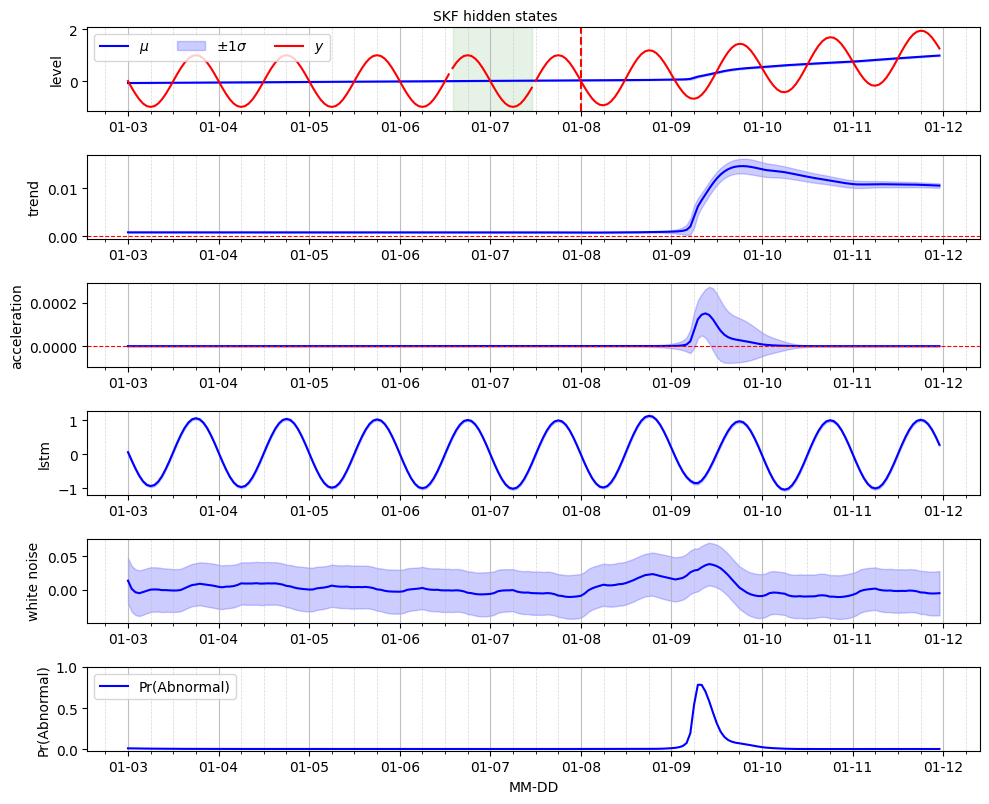

In [14]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    model_prob=filter_marginal_abnorm_prob,
    legend_location="upper left",
)
ax[0].axvline(
    x=data_processor.data.index[time_anomaly],
    color="r",
    linestyle="--",
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)
ax[-1].set_xlabel("MM-DD") 
plt.show()